In [1]:
import numpy as np
from elephant import spike_train_generation
from elephant import statistics
import quantities as pq
from scipy.stats import linregress
from scipy.interpolate import make_interp_spline
from neo.io import get_io
from neo import SpikeTrain
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt


In [2]:
listFile = ['GrC_Subject15_180116/180116_0005 CC step.abf',
 'GrC_Subject06_090216/090216_0003 CC step.abf',
 'GrC_Subject10_111018/111018_0001 CC step.abf']

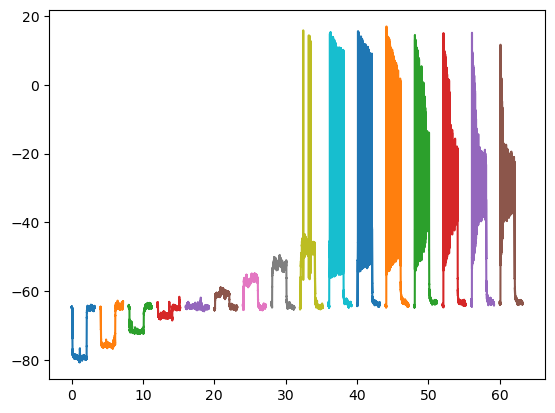

In [4]:
data = get_io('GrC_Subject10_111018/111018_0001 CC step.abf').read(lazy=True)
for y, segment in enumerate(data[0].segments):
    seg = data[0].segments[y].analogsignals[0].load()
    time= seg.times
    plt.plot(time,segment.analogsignals[0].load())


In [3]:
freqI=[]
freqF=[]
for file_path in listFile:
    l1=[]
    l2=[]
    data = get_io(file_path).read()
    for y, segment in enumerate(data[0].segments):
        seg=data[0].segments[y].analogsignals[0]
        time= seg.times
        spike_times=spike_train_generation.spike_extraction(seg)
        if y >=8 and y<=14: # corresponding to the x axis Fig1c and Fig1d
            train = SpikeTrain(spike_times, t_stop=time[-1], units='s')
            rateI = float(statistics.mean_firing_rate(train,t_start=time[0]+100*pq.ms,t_stop=time[0]+600*pq.ms).magnitude)
            rateF = float(statistics.mean_firing_rate(train,t_start=time[0]+1600*pq.ms,t_stop=time[0]+2100*pq.ms).magnitude)
            l1.append(rateI)
            l2.append(rateF)
    freqI.append(l1)
    freqF.append(l2)
    
listIFC=[]
for i in range(len(freqI)):
    l=[]
    for y in range(len(freqI[i])):
        a=(freqF[i][y]-freqI[i][y])
        b=freqI[i][y]
        
        ifc=(a/b)*100
        l.append(ifc)
    listIFC.append(l)

[-100.0, -90.9090909090909, -35.714285714285715, 16.0, -35.483870967741936, -70.0, -100.0]
[37.5, 0.0, -7.894736842105263, -8.695652173913043, -23.214285714285715, -14.545454545454545, -16.363636363636363]
[-100.0, 87.5, -8.823529411764707, -41.66666666666667, -100.0, -100.0, -100.0]


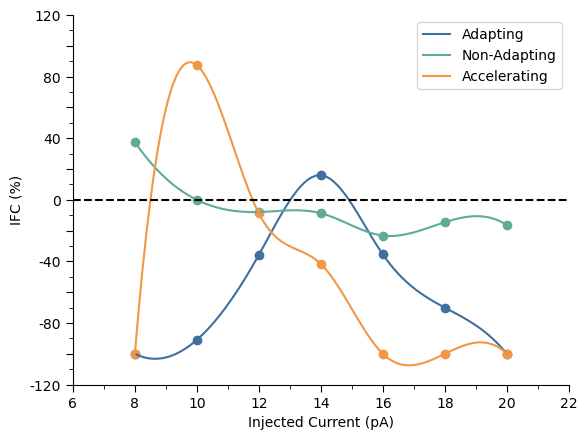

In [4]:
listCurrent= list(np.arange(8,22,2))
colors = ['#3f709e', '#5fab99', '#f29744' ]
legend =["Adapting","Non-Adapting","Accelerating"]

for i in range(len(listIFC)):
    print(listIFC[i])
    model=make_interp_spline(listCurrent,listIFC[i])
    xs=np.linspace(8,20,100) #smoothing of the line
    ys=model(xs)

    plt.plot(xs, ys, color=colors[i], label=legend[i])
    plt.scatter(listCurrent,listIFC[i], color=colors[i])


ax = plt.gca()

ax.set_xticks([6, 8, 10, 12, 14, 16, 18, 20, 22])  
ax.tick_params(axis='x', which='major', size=5)  
ax.set_xticks([7, 9, 11, 13, 15, 17, 19, 21, 23], minor=True) 
ax.tick_params(axis='x', which='minor', size=3)  
ax.set_xlim(6, 22)  


ax.set_ylim(-120, 120)  
ax.set_yticks([-120, -100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120])  
ax.tick_params(axis='y', which='major', size=5)  
ax.set_yticks([-110, -90, -70, -50, -30, -10, 10, 30, 50, 70, 90, 110], minor=True) 
ax.tick_params(axis='y', which='minor', size=3)  
ax.set_yticklabels(['-120', '', '-80', '', '-40', '', '0', '', '40', '', '80', '', '120'])
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.hlines(y=0, xmin=6, xmax=22, color= 'k', linestyle='--')    
plt.xlabel('Injected Current (pA)')
plt.ylabel('IFC (%)')


plt.legend()
plt.show()

# todo: not the same figure -> to search the data corresponding - not found 
# todo: change the ticks

### Check IFC for 14 pA -> segment 11

In [6]:
freqI=[]
freqF=[]
#with open('Check_IFC_14pA.txt', 'a') as f:
for file_path in listFile:
    #f.write(file_path)
    l1=[]
    l2=[]
    data = get_io(file_path).read()
    seg=data[0].segments[11].analogsignals[0]
    time= seg.times
    spike_times=spike_train_generation.spike_extraction(seg)
    #f.write(str(spike_times))
    train = SpikeTrain(spike_times, t_stop=time[-1], units='s')
    rateI = float(statistics.mean_firing_rate(train,t_start=time[0]+100*pq.ms,t_stop=time[0]+600*pq.ms).magnitude)
    #f.write(str(rateI))
    rateF = float(statistics.mean_firing_rate(train,t_start=time[0]+1600*pq.ms,t_stop=time[0]+2100*pq.ms).magnitude)
    #f.write(str(rateF))
    l1.append(rateI)
    l2.append(rateF)
    #f.write('---other---file----')
freqI.append(l1)
freqF.append(l2)
        
listIFC=[]
for i in range(len(freqI)):
    l=[]
    for y in range(len(freqI[i])):
        a=(freqF[i][y]-freqI[i][y])
        b=freqI[i][y]
        
        ifc=(a/b)*100
        l.append(ifc)
    listIFC.append(l)

### Other ways to calculate firing rate 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from neo.io import AxonIO

def detect_and_refine_spikes(signal, threshold, window_size):
    """
    Détecte les spikes dans un signal en utilisant un seuil, puis affine la détection
    en prenant la valeur la plus haute du spike dans une fenêtre de recherche.

    Parameters:
    - signal: Le signal à analyser (array numpy).
    - threshold: Le seuil pour la détection initiale des spikes.
    - window_size: La taille de la fenêtre de recherche pour affiner les spikes.

    Returns:
    - refined_spike_indices: Les indices des spikes raffinés.
    """
    # Détection des spikes initiale (spikes au-dessus d'un seuil)
    spike_indices = np.where(signal > threshold)[0]

    # Affiner la détection des spikes en prenant la valeur la plus haute du spike
    refined_spike_indices = []
    for idx in spike_indices:
        # Définir la fenêtre de recherche autour de l'indice détecté
        start_idx = max(0, idx - window_size)
        end_idx = min(len(signal) - 1, idx + window_size)
        
        # Trouver l'indice de la valeur maximale dans cette fenêtre
        refined_idx = start_idx + np.argmax(signal[start_idx:end_idx+1])
        
        # Ajouter l'indice raffiné à la liste
        refined_spike_indices.append(refined_idx)

    # Supprimer les doublons
    refined_spike_indices = np.unique(refined_spike_indices)
    
    return refined_spike_indices

def find_edges(signal, spike_indices, derivative_threshold=0.1):
    """
    Trouver les points de début et de fin des potentiels d'action.

    Parameters:
    - signal: Le signal à analyser (array numpy).
    - spike_indices: Les indices des spikes détectés (array numpy).
    - derivative_threshold: Le seuil pour détecter les changements rapides dans le signal.

    Returns:
    - edges: Liste des tuples contenant les indices de début et de fin des potentiels d'action.
    """
    derivative = np.diff(signal)
    
    edges = []
    for idx in spike_indices:
        # Trouver le début du potentiel d'action
        start = np.where(derivative[:idx] < -derivative_threshold)[0]
        start = start[-1] if len(start) > 0 else 0
        
        # Trouver la fin du potentiel d'action
        end = np.where(derivative[idx:] > derivative_threshold)[0]
        end = idx + end[0] if len(end) > 0 else len(signal) - 1
        
        edges.append((start, end))
    return edges

# Charger les données
file_path = "GrC_Subject15_180116/180116_0005 CC step.abf"
reader = AxonIO(file_path)
data = reader.read_block(lazy=False)
seg0 = data.segments[0]
channel0 = seg0.analogsignals[0]

# Conversion en tableau Numpy
channel0np = np.array(channel0).flatten()
times = np.array(channel0.times).flatten()

# Paramètres pour la détection des spikes
threshold = 25  # Ajustez ce seuil en fonction de vos données
window_size = 3  # Taille de la fenêtre pour vérifier les points voisins

# Détection et affinement des spikes
refined_spike_indices = detect_and_refine_spikes(channel0np, threshold, window_size)

# Trouver les débuts et fins des potentiels d'action
edges = find_edges(channel0np, refined_spike_indices)

# Calcul des durées des potentiels d'action
spike_durations = [times[end] - times[start] for start, end in edges]
start_indices = [start for start, end in edges]
end_indices = [end for start, end in edges]

# Calcul des intervalles de temps entre les débuts des spikes successifs
spike_times = times[refined_spike_indices]
intervals = np.diff(spike_times)

# Calcul des fréquences instantanées (inverse des intervalles)
frequencies = 1 / intervals

# Calcul des barres d'erreur (écart-type des fréquences)
mean_freq = np.mean(frequencies)
std_freq = np.std(frequencies)

# Tracer les fréquences des spikes
plt.figure(figsize=(8, 6))
plt.plot(spike_times[1:], frequencies, 'o')
plt.xlabel('Temps (s)')
plt.ylabel('Fréquence instantanée (Hz)')
plt.ylim(0, 60)
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 61, 10))
plt.title('Fréquence instantanée des spikes')
plt.show()


IndexError: arrays used as indices must be of integer (or boolean) type

---------------------------------------------------------------------

In [8]:
# Charger les données
file_path = "GrC_Subject15_180116/180116_0005 CC step.abf"
data = get_io(file_path).read(lazy=False)[0]
signal = data.segments[8].analogsignals[0]


In [9]:
# Conversion en tableau Numpy
signal_np = np.array(signal).flatten()
times = np.array(signal.times).flatten()

# Paramètres pour la détection des spikes
threshold = 0.2  # Ajustez ce seuil en fonction de vos données
window_size = 3  # Taille de la fenêtre pour vérifier les points voisins


In [5]:
freqI=[]
freqF=[]
threshold = 20
data = get_io(file_path).read()

#Wfor y, segment in enumerate(data[0].segments):
    #if y >=8 and y<=14: # corresponding to the x axis Fig1c and Fig1d
seg = data[0].segments[8].analogsignals[0].flatten()
seg_np = np.array(seg).flatten()

print('signal:', seg)
spike_indices = np.where(seg > threshold)[0]
print('spike_indices:',spike_indices)    

signal: [-65.39917  -65.2771   -65.39917  ... -66.467285 -66.467285 -66.345215] mV
spike_indices: [ 733  879 1076 1727 1855 2009 2485 3185 3364 5894 5895 5973 5974 6172
 6173]


NameError: name 'spike_time' is not defined

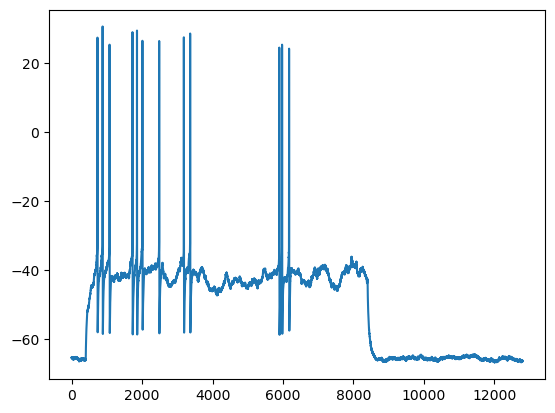

In [12]:
plt.plot(seg_np, label='Signal')
plt.plot(spike_time, signal_np[spike_time], "x", label='Pics')


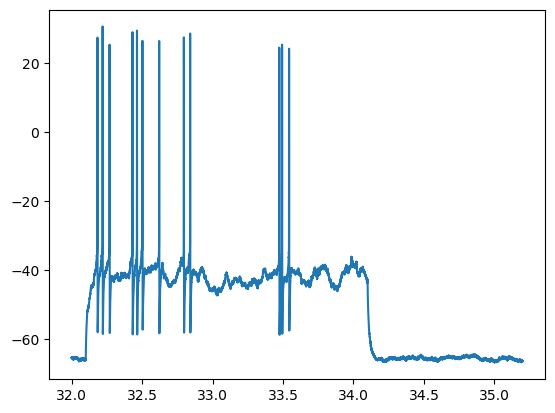

In [10]:
plt.plot(times,seg_np)
plt.plot(times[spike_indices],seg_np[spike_indices])